In [1]:
import tacoma as tc
from tacoma.interactive import visualize
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def convert_csv_to_taco(game, distance_threshold):
    # open gzipped file
    file = f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance_threshold}.csv'
    with open(file, mode='rt') as f:
        reader = csv.reader(f,delimiter=',')

        # mappings of nodes to integers
        node_to_int = {}
        int_to_node = {}

        # get an initial t_old
        # (this is done to detect changes in the tsv)
        t_old = None

        # list of edge lists
        edges = []

        # time points
        time = []

        next(reader) # skip header line
        
        first_data_line = next(reader)
        start_time = np.datetime64(first_data_line[0])
        
        for row in reader:
            row_time = np.datetime64(row[0])
            t = (row_time - start_time).astype(int) #this is to account for the interval choice [t-1s, t]

            # if the time changed, we save the new time and
            # prepare to save new edges
            if t_old != t:

                # When the time changed more than dt,
                # append an instance of an empty edge list
                # at t = t_old + dt
                if (t_old is not None) and (t - t_old > 1):
                    edges.append([])
                    time.append(t_old+1)

                edges.append([])
                time.append(t)

            # get the edge
            i = row[1]
            j = row[2]

            # map the edge to integers
            if i not in node_to_int:
                this_int = len(node_to_int)
                node_to_int[i] = len(node_to_int)
                int_to_node[this_int] = str(i)

            if j not in node_to_int:
                this_int = len(node_to_int)
                node_to_int[j] = len(node_to_int)
                int_to_node[this_int] = str(j)

            # save the edge
            edges[-1].append(tuple(sorted([
                                    node_to_int[i],
                                    node_to_int[j]
                                    ])))
            t_old = t

        N = len(node_to_int)
        tmax = time[-1] + 1


    # get a new `edge_lists` instance
    el = tc.edge_lists()

    el.N = N
    el.tmax = tmax
    el.edges = edges
    el.t = time
    el.time_unit = 's'
    el.int_to_node = int_to_node

    # verifying that this is a valid temporal network
    tc.verify(el)

    # save this edge_lists instance
    with open(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance_threshold}.taco','w') as f:
        tc.write_json_taco(el,f)

In [4]:
# Crée les .taco à partir des contact datasets - 2-3min
for game in range(1,7):
    for distance in range(5, 201, 5):
        if game==5 and distance==5:
            continue
        convert_csv_to_taco(game, distance)

In [2]:
# Animation du dataset - Fermer en interrompant la cellule
game = 3
distance_threshold = 50
temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance_threshold}.taco')
visualize(temporal_network, frame_dt = 1)

changing directory to C:\Users\frank\.tacoma\web
starting server here ... C:\Users\frank\.tacoma\web
preparing network 


127.0.0.1 - - [17/May/2023 11:58:46] "GET /?data=tmp_1882a6f6fa3 HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 11:58:46] "GET /tmp_1882a6f6fa3_config.json HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 11:58:46] "GET /tmp_1882a6f6fa3/tmp_1882a6f6fa3_0.taco HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 11:58:47] "GET /tmp_1882a6f6fa3/tmp_1882a6f6fa3_0.json HTTP/1.1" 200 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to C:\Users\frank\OneDrive\Documents\Uni\Doctorat\TemporalMobility\ecology2023\exploration


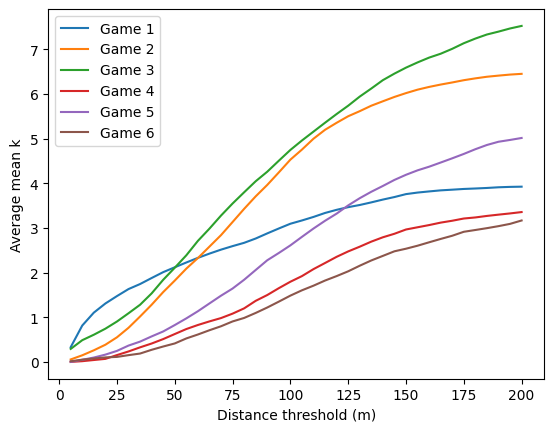

In [4]:
# Mean degrees
distances = np.linspace(5, 200, 40, dtype=int)

for game in range(1,7):
    average_mean_k_list = []
    for distance in distances:
        if game==4 and distance==5:
            average_mean_k_list.append(0)
            continue
        elif game==5 and distance==5:
            average_mean_k_list.append(0)
            continue
        temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance}.taco')
        t, mean_k = tc.mean_degree(temporal_network)
        average_mean_k = tc.time_average(t, mean_k, tmax=temporal_network.tmax)
        average_mean_k_list.append(average_mean_k)
    plt.plot(distances, average_mean_k_list, label=f"Game {game}")

plt.xlabel("Distance threshold (m)")
plt.ylabel("Average mean k")  # Average sur le temps du degré moyen
plt.legend()
plt.show()

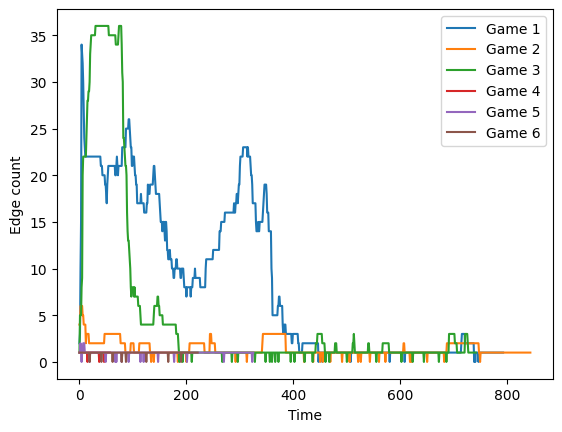

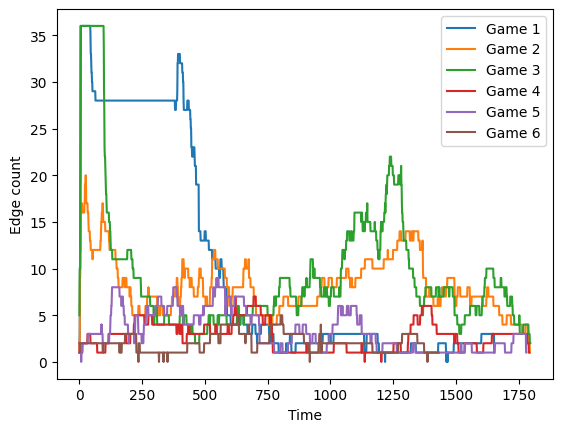

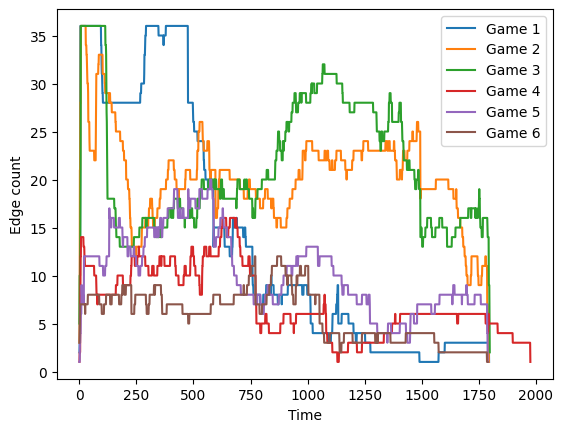

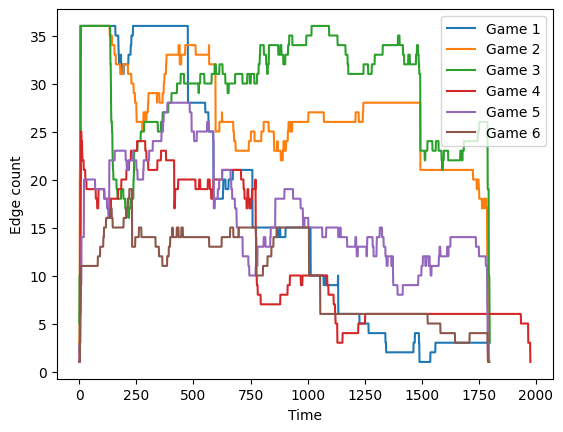

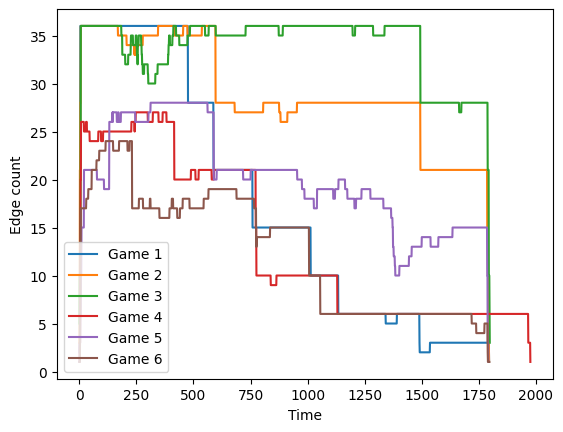

In [5]:
# Edge counts for different games and different treshold distances
distances = [10, 50, 100, 150, 200]

for distance in distances:
    for game in range(1,7):
        temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance}.taco')
        m_in, m_out, m = tc.edge_counts(temporal_network)

        plt.plot(m, label=f"Game {game}")

    plt.xlabel("Time")
    plt.ylabel("Edge count")
    plt.legend()
    plt.show()

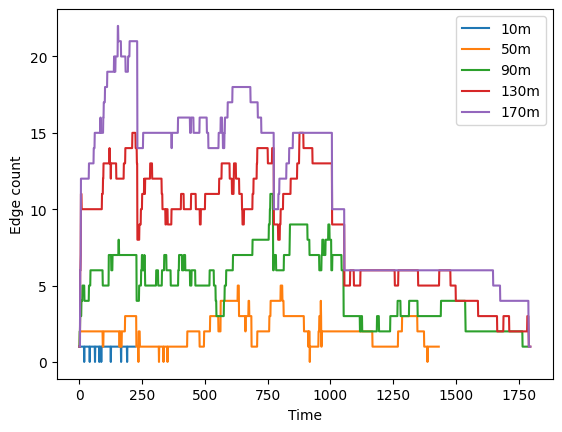

In [7]:
# Quantify activity for different treshold distances

game = 6

for distance in range(10, 200, 40):
    temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance}.taco')
    m_in, m_out, m = tc.edge_counts(temporal_network)

    plt.plot(m, label=f"{distance}m")
    
plt.xlabel("Time")
plt.ylabel("Edge count")
plt.legend()
plt.show()

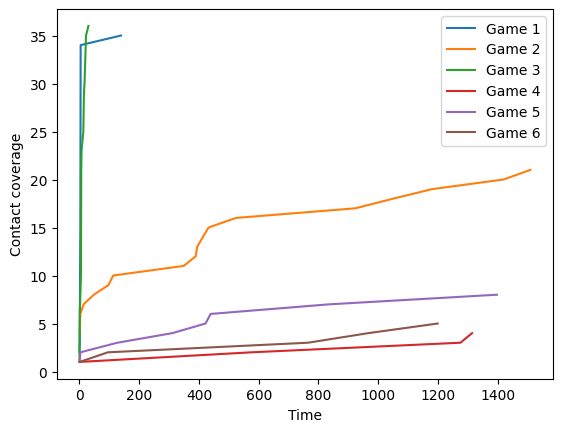

In [9]:
# Contact coverage
distance = 10

for game in range(1,7):
    temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance}.taco')
    t, C = tc.contact_coverage(temporal_network)
    plt.plot(t, C, label=f'Game {game}')
    
plt.xlabel('Time')
plt.ylabel('Contact coverage')
plt.legend()
plt.show()

Mean group size : 1.3808550351079905
Mean number of groups : 5.79351184346035
Mean coordination number : 0.773043254376931


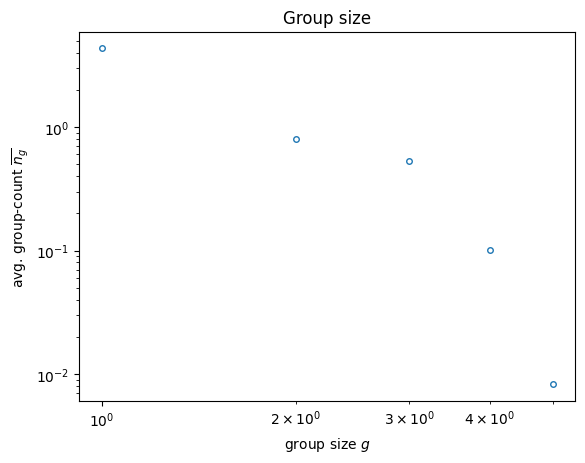

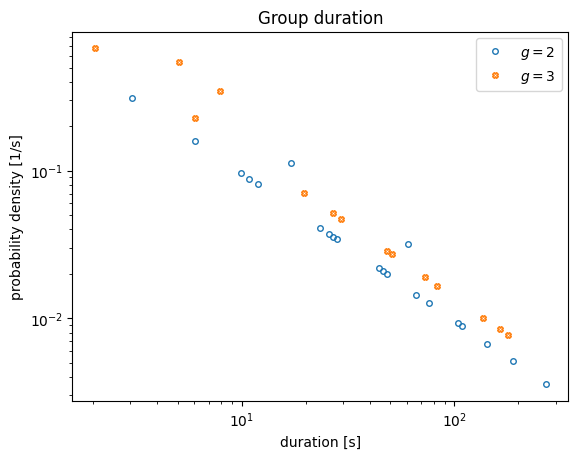

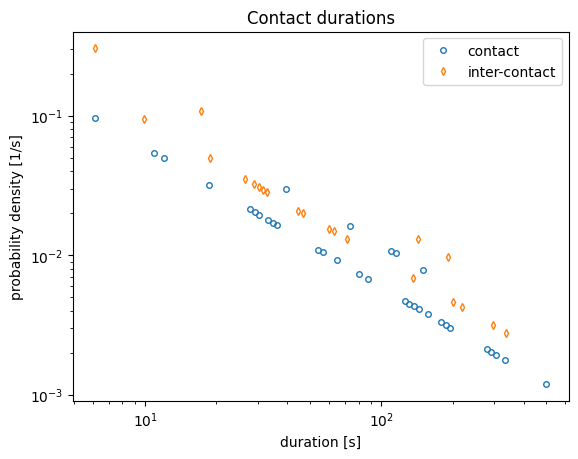

In [10]:
# Groups
from tacoma.analysis import plot_group_size_histogram
from tacoma.analysis import plot_group_durations
from tacoma.analysis import plot_contact_durations


game = 4
distance = 50

temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance}.taco')
result = tc.measure_group_sizes_and_durations(temporal_network)
g, N_g = tc.group_size_histogram(result)
mean_g = tc.mean_group_size(result)
mean_c = tc.mean_number_of_groups(result)
mean_n = tc.mean_coordination_number(result)

print(f'Mean group size : {mean_g}')
print(f'Mean number of groups : {mean_c}')
print(f'Mean coordination number : {mean_n}')

fig, ax = plt.subplots(1,1)
plot_group_size_histogram(result, ax)
plt.title('Group size')
plt.show()

fig, ax = plt.subplots(1,1)
plot_group_durations(result, ax, time_unit='s')
plt.title('Group duration')
plt.show()

fig, ax = plt.subplots(1,1)
plot_contact_durations(result, ax, time_unit='s', use_logarithmic_histogram=True)
plt.title('Contact durations')
plt.show()
# plt.savefig('inter-event_and_event_durations.pdf')

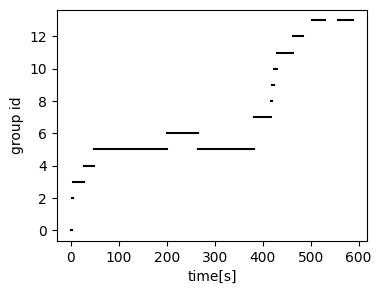

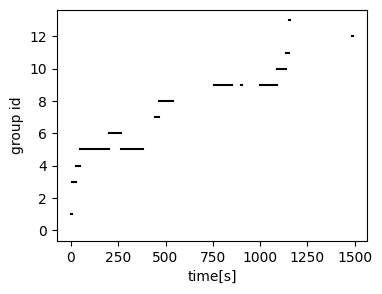

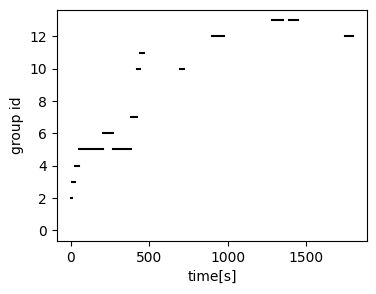

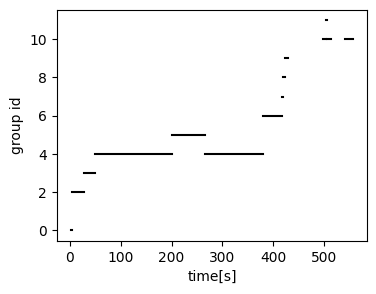

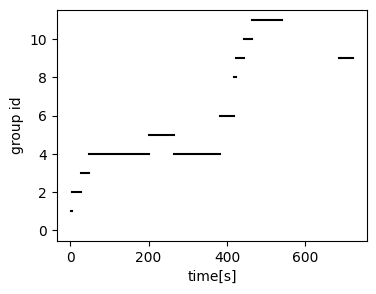

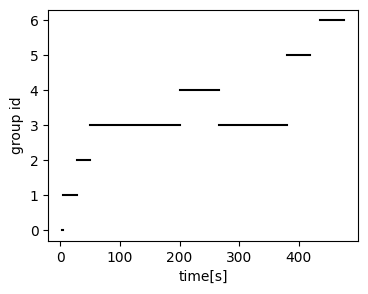

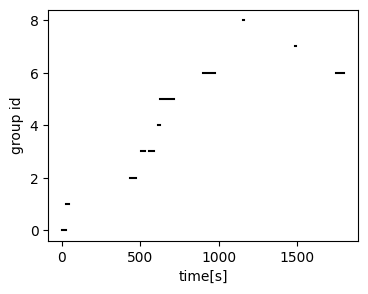

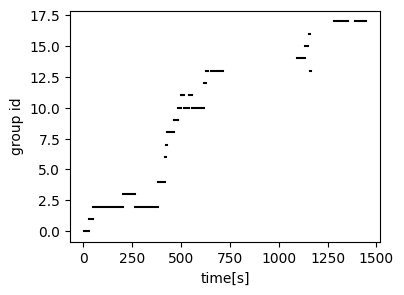

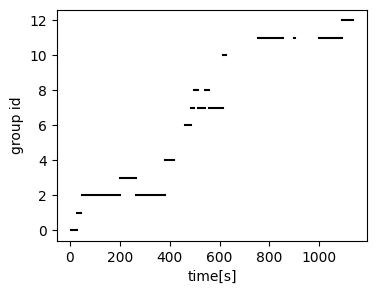

In [11]:
# Social trajectories
from tacoma.analysis import plot_social_trajectory
import matplotlib.pyplot as plt

game = 1
distance = 20

for node in range(9):
    temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance}.taco')
    soc_traj = tc.social_trajectory(temporal_network, node=node)

    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    plot_social_trajectory(soc_traj, ax, time_unit='s')
    plt.show()

# Inter-event times
Ici, le but c'est de calculer les inter-event times et de plotter leur distribution, un peu comme les contact durations déjà implémentées dans Tacoma, mais pour les temps de chasse et d'interactions entre proies/prédateurs.

In [12]:
def get_int_to_role_dict(game, temporal_network):
    player_df = pd.read_csv("../data/2022_05/Player_data.csv", sep=';')
    game_groups = player_df.groupby(["Game"])
    game_player_df = game_groups.get_group(game)
    player_role_dict = pd.Series(game_player_df.Role.values,index=game_player_df.Player_ID).to_dict()
    int_to_role_dict = {}
    int_to_player_dict = temporal_network.int_to_node
    for node_int in int_to_player_dict:
        if player_role_dict[int_to_player_dict[node_int]] == "Apex":
            int_to_role_dict[node_int] = 2
        elif player_role_dict[int_to_player_dict[node_int]] == "Meso":
            int_to_role_dict[node_int] = 1
        elif player_role_dict[int_to_player_dict[node_int]] == "Prey":
            int_to_role_dict[node_int] = 0
    return int_to_role_dict


def get_mean_std_and_burstiness_parameter(inter_event_times):
    mean = np.average(inter_event_times)
    std = np.std(inter_event_times)
    B = (std - mean)/(std + mean)
    return mean, std, B

def get_mean_std_and_revised_burstiness_parameter(inter_event_times):
    mean = np.average(inter_event_times)
    std = np.std(inter_event_times)
    r = std/mean
    n = len(inter_event_times)
    Bn = (np.sqrt(n+1)*r - np.sqrt(n-1)) / ((np.sqrt(n+1) - 2)*r + np.sqrt(n+1))
    return mean, std, Bn

def get_local_variation(inter_event_times):
    LV = 0
    for i in range(1, len(inter_event_times)-1):
        LV += 3*(inter_event_times[i] - inter_event_times[i+1])**2 / (inter_event_times[i] + inter_event_times[i+1])**2
    LV /= i
    return LV

In [19]:
# Extract hunt times, times between hunts, interaction times, and times between interactions
# Calculate coefficients to quantify how bursty the dataset is
distance_threshold = 25

hunt_times = []
inter_hunt_times = []
interaction_times = []
inter_interaction_times = []
for game in range(1,7):
    file = f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance_threshold}.csv'

    temporal_network = tc.load_json_taco(f'../data/2022_05/thresholded_edgelists/edgelist_game{game}_thresh{distance_threshold}.taco')
    temporal_network = tc.convert_to_edge_trajectories(temporal_network)

    int_to_role_dict = get_int_to_role_dict(game, temporal_network)

    for trajectory in temporal_network.trajectories:
        node1 = trajectory.edge[0]
        node2 = trajectory.edge[1]
        role_pair = sorted((int_to_role_dict[node1], int_to_role_dict[node2]))
        role_comparison = role_pair[1] - role_pair[0]  # == 0 if interaction, > 1 if hunt
        if role_comparison > 1:
            end_time = 0
            for time_pair in trajectory.time_pairs:
                hunt_times.append(time_pair[1] - time_pair[0])
                if end_time != 0:
                    inter_hunt_times.append(time_pair[0] - end_time)
                end_time = time_pair[1]
        elif role_comparison == 0:
            end_time = 0
            for time_pair in trajectory.time_pairs:
                interaction_times.append(time_pair[1] - time_pair[0])
                if end_time != 0:
                    inter_interaction_times.append(time_pair[0] - end_time)
                end_time = time_pair[1]

mean_hunt_time, std_hunt_time, B_hunt_time = get_mean_std_and_burstiness_parameter(hunt_times)
mean_inter_hunt_time, std_inter_hunt_time, B_inter_hunt_time = get_mean_std_and_burstiness_parameter(inter_hunt_times)
mean_interaction_time, std_interaction_time, B_interaction_time = get_mean_std_and_burstiness_parameter(interaction_times)
mean_inter_interaction_time, std_inter_interaction_time, B_inter_interaction_time = get_mean_std_and_burstiness_parameter(inter_interaction_times)
Bn_hunt_time = get_mean_std_and_revised_burstiness_parameter(hunt_times)[2]
Bn_inter_hunt_time = get_mean_std_and_revised_burstiness_parameter(inter_hunt_times)[2]
Bn_interaction_time = get_mean_std_and_revised_burstiness_parameter(interaction_times)[2]
Bn_inter_interaction_time = get_mean_std_and_revised_burstiness_parameter(inter_interaction_times)[2]

print('Burstiness parameters')
print(f'hunt : B = {B_hunt_time}, Bn = {Bn_hunt_time}')
print(f'inter hunt : B = {B_inter_hunt_time}, Bn = {Bn_inter_hunt_time}')
print(f'interaction : B = {B_interaction_time}, Bn = {Bn_interaction_time}')
print(f'inter interaction : B = {B_inter_interaction_time}, Bn = {Bn_inter_interaction_time}')

LV_hunt = get_local_variation(hunt_times)
LV_inter_hunt = get_local_variation(inter_hunt_times)
LV_interaction = get_local_variation(interaction_times)
LV_inter_interaction = get_local_variation(inter_interaction_times)

print('Memory coefficients')
print(f'hunt : LV = {LV_hunt}')
print(f'inter hunt : LV = {LV_inter_hunt}')
print(f'interaction : LV = {LV_interaction}')
print(f'inter interaction : LV = {LV_inter_interaction}')

Burstiness parameters
hunt : B = -0.11645119049044453, Bn = -0.1215666841015005
inter hunt : B = -0.017983931024945513, Bn = -0.013314616698696545
interaction : B = 0.025041968182965425, Bn = 0.02971082956738692
inter interaction : B = 0.18284889741011587, Bn = 0.20967767288972186
Memory coefficients
hunt : LV = 0.7077031371778726
inter hunt : LV = 1.276797533757873
interaction : LV = 1.0778091530761154
inter interaction : LV = 1.2748353680896298


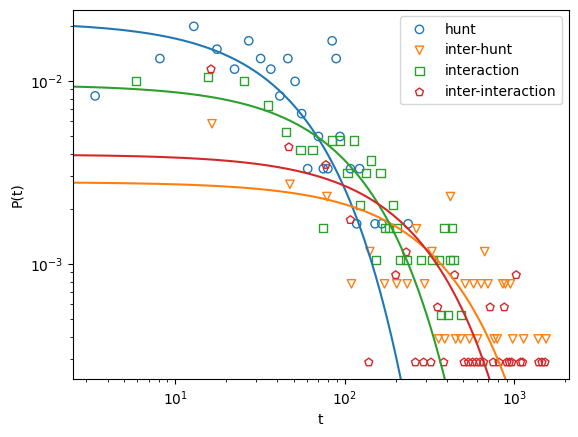

In [22]:
# Plot probability distributions for the inter event times - Uniform bins
number_of_bins = 50

y, x = np.histogram(hunt_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='tab:blue', label='hunt')

y, x = np.histogram(inter_hunt_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
plt.scatter(x, y, marker='v', facecolors='none', edgecolors='tab:orange', label='inter-hunt')

y, x = np.histogram(interaction_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
plt.scatter(x, y, marker='s', facecolors='none', edgecolors='tab:green', label='interaction')

y, x = np.histogram(inter_interaction_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
plt.scatter(x, y, marker='p', facecolors='none', edgecolors='tab:red', label='inter-interaction')

plt.xscale('log')
plt.yscale('log')

axes = plt.gca()
plt.xlim(axes.get_xlim())
plt.ylim(axes.get_ylim())

x = np.arange(0, 10e4, 1)
plt.plot(x, 1/mean_hunt_time*np.exp(-(x/mean_hunt_time)))
plt.plot(x, 1/mean_inter_hunt_time*np.exp(-(x/mean_inter_hunt_time)))
plt.plot(x, 1/mean_interaction_time*np.exp(-(x/mean_interaction_time)))
plt.plot(x, 1/mean_inter_interaction_time*np.exp(-(x/mean_inter_interaction_time)))

plt.xlabel('t')
plt.ylabel('P(t)')
plt.legend()
plt.show()

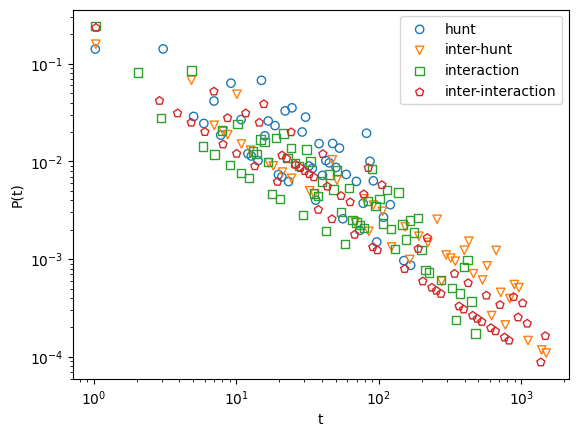

In [23]:
# Plot probability distributions for the inter event times - Logarithmic bins
number_of_bins = 100

x, y = tc.tools.get_logarithmic_histogram(hunt_times, bins=number_of_bins, density=True)
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='tab:blue', label='hunt')

x, y = tc.tools.get_logarithmic_histogram(inter_hunt_times, bins=number_of_bins, density=True)
plt.scatter(x, y, marker='v', facecolors='none', edgecolors='tab:orange', label='inter-hunt')

x, y = tc.tools.get_logarithmic_histogram(interaction_times, bins=number_of_bins, density=True)
plt.scatter(x, y, marker='s', facecolors='none', edgecolors='tab:green', label='interaction')

x, y = tc.tools.get_logarithmic_histogram(inter_interaction_times, bins=number_of_bins, density=True)
plt.scatter(x, y, marker='p', facecolors='none', edgecolors='tab:red', label='inter-interaction')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('t')
plt.ylabel('P(t)')
plt.legend()
plt.show()

# Compare logarithmic bins vs. uniform bins

In [16]:
import numpy as np
from scipy.stats import pareto, uniform, expon
import matplotlib.pyplot as plt

b = 2.62
sample_size = 180

r1 = pareto.rvs(b, size=sample_size)
r2 = uniform.rvs(size = sample_size)
r3 = expon.rvs(size=sample_size)

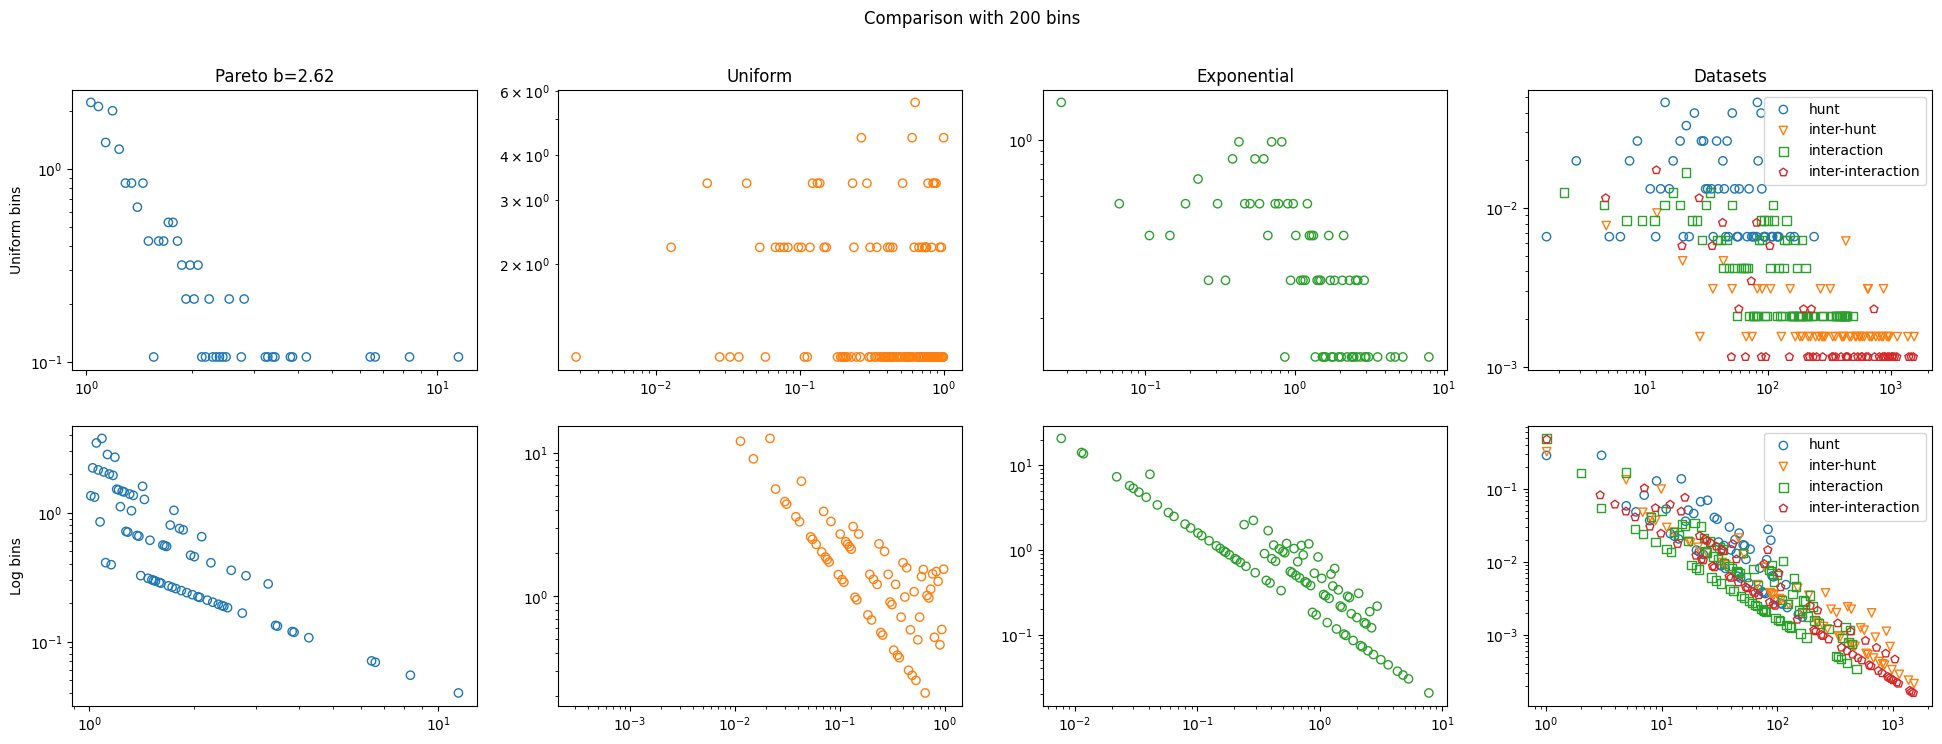

In [17]:
fig, ax = plt.subplots(2,4, figsize=(24,8))
number_of_bins = 200

y, x = np.histogram(r1, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
ax[0,0].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:blue', label='Pareto')
ax[0,0].loglog()
ax[0,0].set_title(f'Pareto b={b}')
ax[0,0].set_ylabel('Uniform bins')

y, x = np.histogram(r2, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
ax[0,1].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:orange', label='Uniform')
ax[0,1].loglog()
ax[0,1].set_title('Uniform')

y, x = np.histogram(r3, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
ax[0,2].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:green', label='Exponential')
ax[0,2].loglog()
ax[0,2].set_title('Exponential')



x, y = tc.tools.get_logarithmic_histogram(r1, bins=number_of_bins, density=True)
ax[1,0].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:blue', label='Pareto')
ax[1,0].loglog()
ax[1,0].set_ylabel('Log bins')

x, y = tc.tools.get_logarithmic_histogram(r2, bins=number_of_bins, density=True)
ax[1,1].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:orange', label='Uniform')
ax[1,1].loglog()

x, y = tc.tools.get_logarithmic_histogram(r3, bins=number_of_bins, density=True)
ax[1,2].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:green', label='Exponential')
ax[1,2].loglog()



y, x = np.histogram(hunt_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
ax[0,3].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:blue', label='hunt')

y, x = np.histogram(inter_hunt_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
ax[0,3].scatter(x, y, marker='v', facecolors='none', edgecolors='tab:orange', label='inter-hunt')

y, x = np.histogram(interaction_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
ax[0,3].scatter(x, y, marker='s', facecolors='none', edgecolors='tab:green', label='interaction')

y, x = np.histogram(inter_interaction_times, bins=number_of_bins, density=True)
x = 0.5*(x[1:]+x[:-1])
ax[0,3].scatter(x, y, marker='p', facecolors='none', edgecolors='tab:red', label='inter-interaction')
ax[0,3].loglog()
ax[0,3].legend()
ax[0,3].set_title('Datasets')


x, y = tc.tools.get_logarithmic_histogram(hunt_times, bins=number_of_bins, density=True)
ax[1,3].scatter(x, y, marker='o', facecolors='none', edgecolors='tab:blue', label='hunt')

x, y = tc.tools.get_logarithmic_histogram(inter_hunt_times, bins=number_of_bins, density=True)
ax[1,3].scatter(x, y, marker='v', facecolors='none', edgecolors='tab:orange', label='inter-hunt')

x, y = tc.tools.get_logarithmic_histogram(interaction_times, bins=number_of_bins, density=True)
ax[1,3].scatter(x, y, marker='s', facecolors='none', edgecolors='tab:green', label='interaction')

x, y = tc.tools.get_logarithmic_histogram(inter_interaction_times, bins=number_of_bins, density=True)
ax[1,3].scatter(x, y, marker='p', facecolors='none', edgecolors='tab:red', label='inter-interaction')
ax[1,3].loglog()
ax[1,3].legend()

plt.suptitle(f'Comparison with {number_of_bins} bins')
# plt.savefig(f'Comparaison_log_vs_uniform_{number_of_bins}bins.pdf')
plt.show()